In [114]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from tabulate import tabulate
import string

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
color_map_name = "nipy_spectral"
cmap = matplotlib.colormaps[color_map_name]  
full_group_name2idx_map = {
    "primates": 0,
    "mammals": 1, 
    "birds": 2,
    "reptiles": 3,
    "fish": 4,
    "arthropods": 5,
    "nematodes": 6,
    "plants": 7,
    "fungi": 8,
    "others": 9
}

vertebrate_group_name2idx_map = {
    "primates": 0,
    "mammals": 1, 
    "birds": 2,
    "reptiles": 3,
    "fish": 4
}

animal_group_name2idx_map = {
    "primates": 0,
    "mammals": 1, 
    "birds": 2,
    "reptiles": 3,
    "fish": 4,
    "arthropods": 5,
    "nematodes": 6
}

In [4]:
df_all = pd.read_csv("output/processed_mutation_rate_estimate.csv")
vertebrate_set = set(vertebrate_group_name2idx_map.keys())
vertebrate_mask = df_all["group2"].isin(vertebrate_set)
df_vertebrate = df_all[vertebrate_mask]
df_vertebrate.to_csv("output/df_vertebrate.csv")
assert set(df_vertebrate["group2"].unique()) == vertebrate_set
print(f"there are {len(df_all)} species with snp mutation rate estimates AND Ne estimates in the dataset\nthere are {len(df_vertebrate)} vertebrate species")

there are 102 species with snp mutation rate estimates AND Ne estimates in the dataset
there are 72 vertebrate species


## This following section plots the DBH relationships

In [7]:
def get_Ne_ranking(df):
    """helper function, rank the species by Ne"""
    df_ne_sorted = df.sort_values(by=["Ne"], ascending=False)
    print(df_ne_sorted[["Ne", "species", "group2", "u_mean"]].head(50))
    
def get_Ne_bounds(df):
    ''' get the minimum and maximum Ne and Ne for all species in the dataframe'''
    def get_min_and_max(df, column_name):
        return np.array([np.min(df[column_name]), np.max(df[column_name])])
        
    bounds_dict = dict()
    bounds_dict["Ne"] = get_min_and_max(df, "Ne")
    bounds_dict["Ne*gen"] = get_min_and_max(df, "Ne*gen")
    return bounds_dict 

def plot_color_gradients(cmap_name, ax):
    """helper function, given a cmap name, visualize its color gradient"""
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    ax.imshow(gradient, aspect='auto', cmap=matplotlib.colormaps[cmap_name])
    ax.set_axis_off()

def get_color_index(num_groups, group_name_index):
    """Calculate an decimal index between (0.05, 1)"""
    return 1 - (0.05+ (1-0.05) / num_groups * group_name_index)

def plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, mutation_rate_unit, ne_unit, ax=None, add_legend=True, label_fontsize=15):
    """helper function, plot mutation rate vs effective population size, given the unit for mu and Ne"""
    mu_key = "u_mean" if mutation_rate_unit == "generation" else "u_mean_year"
    ne_key = "Ne" if ne_unit == "Ne" else "Ne*gen"
    if ax is None:
        fig, ax = plt.subplots()
        
    # due to renaming to stay consistent with phylogenetic tree
    df_human = df.loc[df.index[df["species"] == "Homo sapiens neanderthalensis"]]
    human_ne, human_mu = df_human[ne_key].to_numpy()[0], df_human[mu_key].to_numpy()[0]
    df_mice = df.loc[df.index[df["species"] == "Mus musculus musculus"]]
    mice_ne, mice_mu = df_mice[ne_key].to_numpy()[0], df_mice[mu_key].to_numpy()[0]
    ax.scatter(human_ne, human_mu, color=colors[group_name2idx_map["primates"]], 
               marker='D', edgecolor="black", s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mice_ne, mice_mu, color=colors[group_name2idx_map["mammals"]], 
               marker='D', edgecolor="blue", s=100, lw=2, zorder=float("inf")) #label="mice"
    offset_factor=1.1
    ax.text(offset_factor * human_ne, offset_factor * human_mu, "human", zorder=float("inf"), fontsize=15)
    ax.text(offset_factor * mice_ne, offset_factor * mice_mu, "mouse", zorder=float("inf"), fontsize=15)
    
    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group2"] == gn]]
        if gn == "mammals":
            gn = "non-primate mammals"
        ax.scatter(df_gn[ne_key], df_gn[mu_key], color=colors[idx], label=gn)
    
    if add_legend:
        ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    xlabel = r"$\bf{N_e}$" if ne_unit == "Ne" else r"$\bf{N_e} \times$ generation time" 
    ax.set_xlabel(xlabel, fontsize=label_fontsize, weight="bold")
    ax.set_ylabel(f"mutation rate (/{mutation_rate_unit})", fontsize=label_fontsize, weight="bold")
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    
    # grid line
    ax.grid(which="major", linestyle = "dashed")
    ax.set_axisbelow(True)
    
def format_axis_ticks(ax, which_axis, keep_labels=False, keep_ticks=False, which="both"):
    # which \in ["both", "minor", "major"]
    # which_axis \in ["x", "y", "both"]
    if which_axis == "x":
        ax.tick_params(which=which, bottom=keep_ticks)
        ax.tick_params(labelbottom=keep_labels)
    elif which_axis == "y":
        ax.tick_params(which=which, left=keep_ticks, labelleft=keep_labels)
    else:
        assert which_axis == "both"
        ax.tick_params(which=which, left=keep_ticks, labelleft=keep_labels, bottom=keep_ticks, labelbottom=keep_labels)

def plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    y = np.power(10, intercept) * np.power(x_bounds, slope)
    ax.plot(x_bounds, y, c="black", linestyle = 'dashed')
    if p_value:
        p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}"
        text = f"slope: {slope:.3f}\np-value: {p_val_str}"
    else:
        text = f"slope: {slope:.3f}"
    ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize)
    
def load_and_plot_r_dbh_output(mutation_rate_unit, ne_unit, ne_bounds, ax=None):
    ''' load the dbh PGLS output (slope, intercept) from R and plot the regression line on plot '''
    mu_str = "u" if mutation_rate_unit == "generation" else "u_year"
    ne_str = "Ne" if ne_unit == "Ne" else "Negen"
    r_filename = f"./output/r/dbh_vertebrate_{ne_str}_{mu_str}.csv"
    df = pd.read_csv(r_filename)
    intercept = df["intercept"].to_numpy()[0]
    slope = df["slope"].to_numpy()[0]
    p_val_slope = df["slope.p"].to_numpy()[0]
    plot_regression_line_on_logscale(intercept, slope, ne_bounds[ne_unit], p_value=p_val_slope, ax=ax)
    return [intercept, slope, p_val_slope]
                     
def generate_manuscript_dbh_plot(df, group_name2idx_map, cmap, vertebrate_bounds, label_fontsize=15, save_figure=False):
    num_groups = len(group_name2idx_map)
    colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]

    fig, ax = plt.subplots(2,2, figsize=(15,10))
    plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, "generation", "Ne", ax=ax[0,0], add_legend=False, label_fontsize=label_fontsize)
    [_, slope, pval] = load_and_plot_r_dbh_output("generation", "Ne", vertebrate_bounds, ax=ax[0,0])
    
    plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, "generation", "Ne*gen", ax=ax[0,1], add_legend=False, label_fontsize=label_fontsize)
    [_, _, pval] = load_and_plot_r_dbh_output("generation", "Ne*gen", vertebrate_bounds, ax=ax[0,1])
    
    plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, "year", "Ne", ax=ax[1,0], add_legend=False, label_fontsize=label_fontsize)
    [_, _, pval] = load_and_plot_r_dbh_output("year", "Ne", vertebrate_bounds, ax=ax[1,0])
    
    plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, "year", "Ne*gen", ax=ax[1,1], add_legend=False, label_fontsize=label_fontsize)
    [_, _, pval] = load_and_plot_r_dbh_output("year", "Ne*gen", vertebrate_bounds, ax=ax[1,1])

    format_axis_ticks(ax[0,1], which_axis="both", keep_labels=False, keep_ticks=False, which="both")
    format_axis_ticks(ax[0,0], which_axis="x", keep_labels=False, keep_ticks=False, which="both")
    format_axis_ticks(ax[1,1], which_axis="y", keep_labels=False, keep_ticks=False, which="both")
    ax[0,0].set(xlabel=None)
    ax[0,1].set(xlabel=None)
    ax[0,1].set(ylabel=None)
    ax[1,1].set(ylabel=None)

    # add subplot label
    panel_idx = 0
    for col in range(2):
        for row in range(2):
            ax[row, col].text(-0.05, 1.01, string.ascii_uppercase[panel_idx], transform=ax[row,col].transAxes, size=20, weight='bold')
            panel_idx += 1
            
    handles, labels = ax[1,1].get_legend_handles_labels()
    num_cols = round((num_groups + 2)/ 2) # +2 for mice and human label
    num_cols = num_groups
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), ncol=num_cols, fontsize=label_fontsize) #bbox_transform=fig.transFigure)
    fig.tight_layout()
    if save_figure:
        fig.savefig("figures/dbh.pdf", bbox_inches='tight')


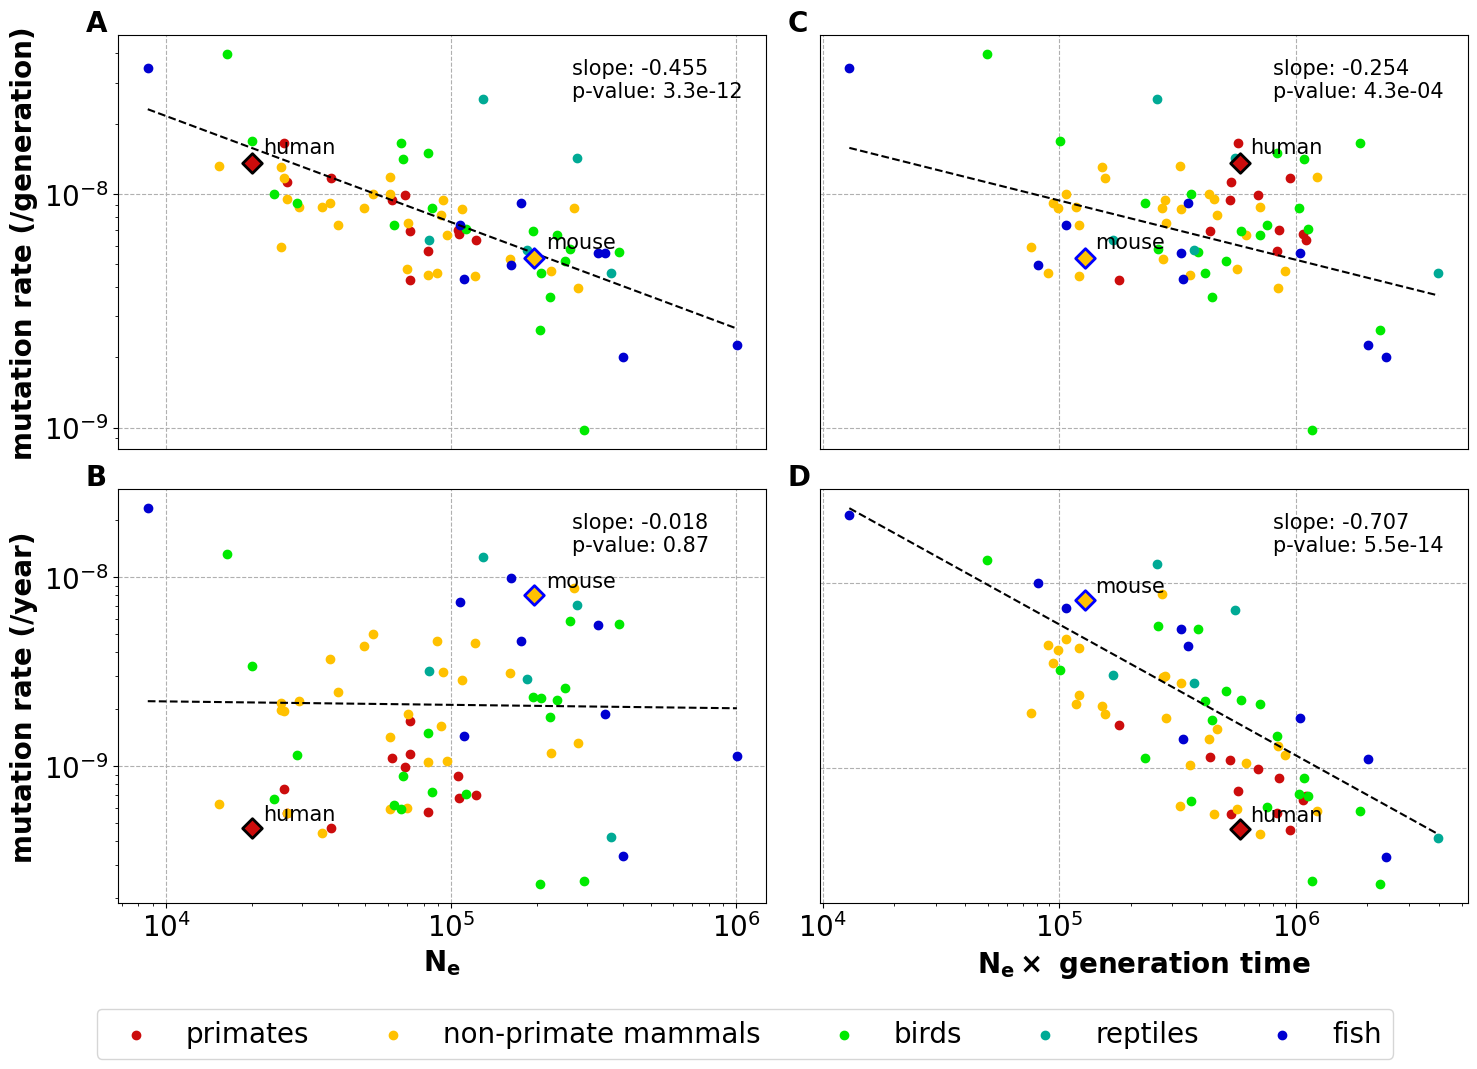

In [6]:
unique_species = df_all["group2"].unique()
assert set(full_group_name2idx_map) == set(unique_species)
vertebrate_bounds = get_Ne_bounds(df_vertebrate)

# generate_manuscript_dbh_plot(
#     df_all, full_group_name2idx_map, cmap, vertebrate_bounds, label_fontsize=20, save_figure=False)

generate_manuscript_dbh_plot(
    df_vertebrate, vertebrate_group_name2idx_map, cmap, vertebrate_bounds, label_fontsize=20, save_figure=False)

## This following section plots the relationship between N_e and generation time

In [93]:
def load_and_plot_r_ne_gen_regression_output(gen_bounds, ax=None):
    r_filename = f"./output/r/gen_Ne.csv"
    df = pd.read_csv(r_filename)
    intercept = df["intercept"].to_numpy()[0]
    slope = df["slope"].to_numpy()[0]
    p_val_slope = df["slope.p"].to_numpy()[0]
    plot_regression_line_on_logscale(intercept, slope, gen_bounds, text_pos=(0.55, 0.9), p_value=p_val_slope, ax=ax)
    
    return [intercept, slope]
    
def plot_Ne_vs_generation_time(df, group_name2idx_map, cmap, label_font_size=15, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    num_groups = len(group_name2idx_map)
    colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]
    df_human = df.loc[df.index[df["species"] == "Homo sapiens neanderthalensis"]]
    human_gen, human_ne = df_human["generation_time_year"].to_numpy()[0], df_human["Ne"].to_numpy()[0]
    
    df_mouse = df.loc[df.index[df["species"] == "Mus musculus musculus"]]
    mouse_gen, mouse_ne = df_mouse["generation_time_year"].to_numpy()[0], df_mouse["Ne"].to_numpy()[0]
    
    ax.scatter(human_gen, human_ne, color=colors[group_name2idx_map["primates"]], 
               edgecolor="black", marker='D', s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mouse_gen, mouse_ne, color=colors[group_name2idx_map["mammals"]], 
               edgecolor="blue", marker='D', s=100, lw=2, zorder=float("inf")) #label="mice"
    
    ax.text(0.42 * human_gen, 0.85 * human_ne, "human", zorder=float("inf"), fontsize=15)
    ax.text(1.1 * mouse_gen, 0.85 * mouse_ne, "mouse", zorder=float("inf"), fontsize=15)

    gen_min, gen_max = np.inf, -1
    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group2"] == gn]]
        label = gn if gn != "mammals" else "non-primate mammals"
        gen_time = df_gn["generation_time_year"].to_numpy()
        gen_min = min(gen_min, np.min(gen_time))
        gen_max = max(gen_max, np.max(gen_time))
        
        Ne = df_gn["Ne"].to_numpy()
        ax.scatter(gen_time, Ne, color=colors[idx], label=label)
    gen_bounds = np.array([gen_min, gen_max])
        
    box = ax.get_position()
    ax.set_xlabel(r"generation time (years)", fontsize=label_font_size, weight="bold")
    ax.set_ylabel(r"$\mathbf{N_e}$", fontsize=label_font_size, weight="bold")
    ax.tick_params(axis='both', which='major', labelsize=13)
    return gen_bounds

def plot_Ne_times_g(regression_slope, gen_bounds, label_font_size=15, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    g = np.linspace(gen_bounds[0], gen_bounds[1], num=50)
    gNe = np.power(g, 1 + regression_slope)

    Ne = 5 * np.power(g, regression_slope) # 5 is an scaling factor to make the two curves look on about the same scale
    ax.text(0.68 * g[-1], 0.95 * gNe[-1], r"$g \times N_e$", fontsize=15)
    ax.text(0.8 * g[-1], 1.2 * Ne[-1], r"$N_e$", fontsize=15)

    ax.plot(g, gNe)
    ax.plot(g, Ne)
    ax.set_xlabel('generation time (years)', fontsize=label_font_size, weight="bold")
    ax.tick_params(axis='y', which='both',labelsize=0, length=0)
    ax.tick_params(axis='x', which='major', labelsize=13)
    bottom, _ = ax.get_ylim()

    y_val_max = max([np.max(Ne), np.max(gNe)])
    ax.set_ylim([bottom, y_val_max * 1.1])

def generate_manuscript_Ne_generation_time_plot(df, group_name2idx_map, cmap, save_figure=False):
    num_groups = len(group_name2idx_map)
    colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    gen_bounds = plot_Ne_vs_generation_time(df, group_name2idx_map, cmap, ax=ax[0], label_font_size=15)
    r_filename = f"./output/r/gen_Ne.csv"
    [_, slope] = load_and_plot_r_regression_output(r_filename, gen_bounds, text_pos=(0.5, 0.85), fontsize=15, log_scale=True, ax=ax[0], 
                                      label=None, linestyle="dashed", linewidth=1, alpha=1, color="black")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=13, ncol=3) #, borderaxespad=0)
    
    # panel B
    plot_Ne_times_g(slope, gen_bounds, ax=ax[1], label_font_size=15)

    # panel C: dbh plot of mutation rate per year vs Ne * generation_time
    ne_bounds = get_Ne_bounds(df)
    plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, "year", "Ne*gen", ax=ax[2], add_legend=False, label_fontsize=15)
    ax[2].set_ylim([10**(-9.82), 10**(-7.3)])
    r_filename = f"./output/r/dbh_vertebrate_Negen_u_year.csv"
    _ = load_and_plot_r_regression_output(r_filename, ne_bounds["Ne*gen"], text_pos=(0.5, 0.85), fontsize=15, log_scale=True, ax=ax[2], 
                                      label=None, linestyle="dashed", linewidth=1, alpha=1, color="black")
        
    ####
    fig.tight_layout()

    for n, axis in enumerate(ax.flatten()):
        axis.text(0.02, 0.94, string.ascii_uppercase[n], transform=axis.transAxes, size=20, weight='bold')
    if save_figure:
        fig.savefig("figures/figure4_vertebrate_DBH.pdf", bbox_inches='tight')

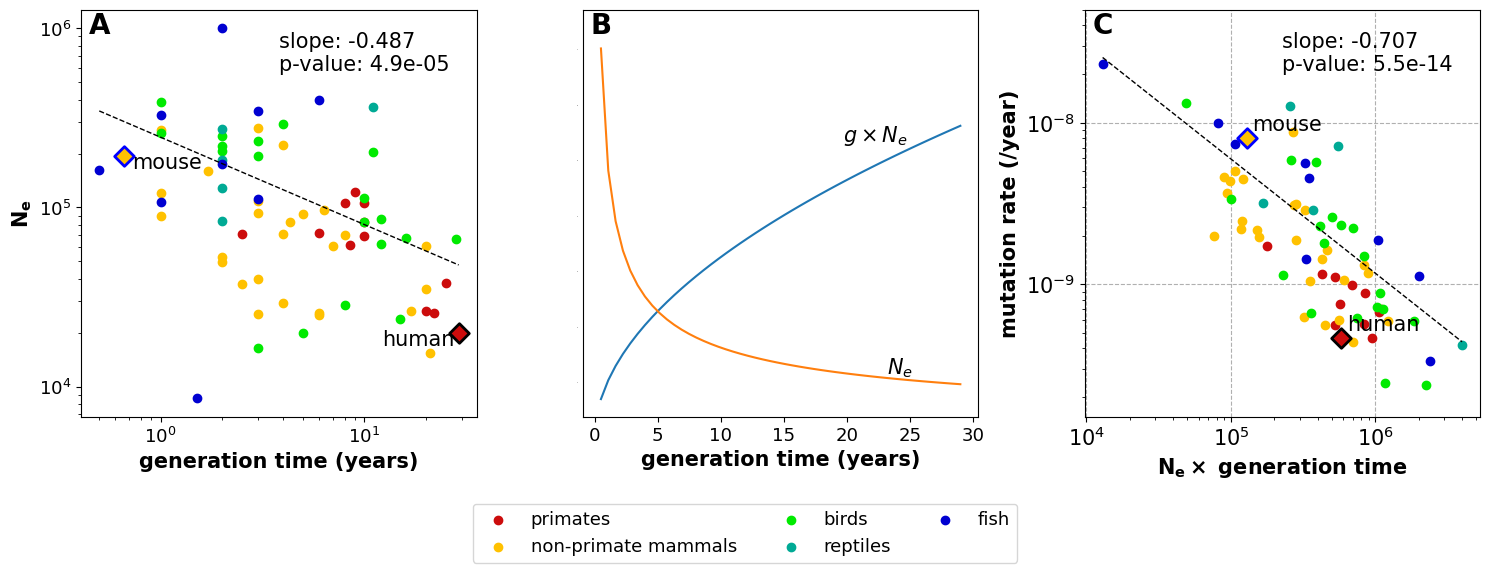

In [94]:
generate_manuscript_Ne_generation_time_plot(df_vertebrate, vertebrate_group_name2idx_map, cmap, save_figure=True)

## This section plots the ratio of (CpG>TpG mutations)/(total mutations) w.r.t. generation time using data from Bergeron 2023. 

after filtering by minimum count, reduced 68 species to 68


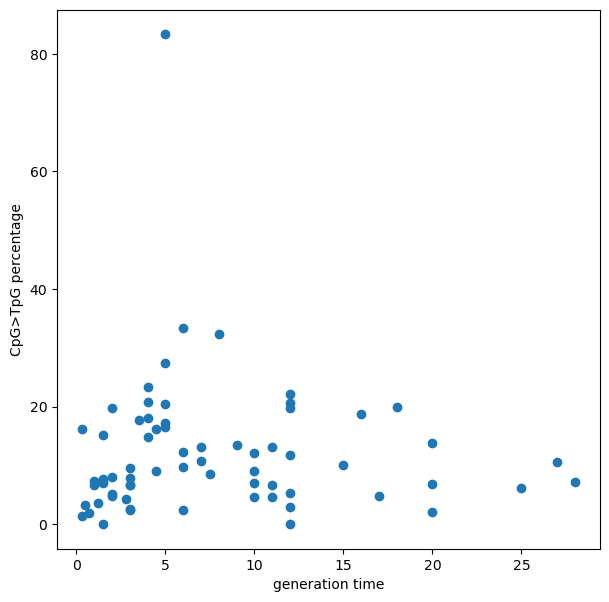

In [9]:
def compute_bergeron_CpG2TpG_percentage():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 4", 
                       header=1, usecols="A:M", skiprows=0)
    # sum up column 2 to 11 (exclusive) to get total mutation count
    df["Mutation count"] = df.iloc[:,2:11].sum(axis=1)
    df["Perc_CpG>TpG"] = (df["% of all mutation in CpG"]/100) * (df["% of C > T in CpG"]/100) * 100
    df = df[["Species", "Group", "Perc_CpG>TpG", "Mutation count"]]
    df.drop(df.tail(1).index,inplace=True)
    return df
    
def load_bergeron_generation_time():
    col_names = ["Species", "Common name", "Group", "Generation time"]
    # U: Unicode string, f: floating point
    data_types = {"Species": 'U', "Common name": 'U', "Group": 'U', "Generation time": 'f'}
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 9", 
                       header=None, names=col_names, dtype=data_types, usecols="A:C,J", skiprows=2)
    # change the species name inigoi to macrolepis to match species name in supplementary table #4 (CpG data)
    # both are dwarf gecko
    df.loc[df["Species"] == "Sphaerodactylus_inigoi", "Species"] = "Sphaerodactylus_macrolepis"
    return df

def plot_bergeron_CpG2TpG_vs_generation_time(min_mutation_count=10):
    def assert_matching_df_keys(df1, df2):
        keys1 = set(df1.apply(lambda x: str(x["Species"]) + "_" + str(x["Group"]), axis=1))
        keys2 = set(df2.apply(lambda x: str(x["Species"]) + "_" + str(x["Group"]), axis=1))
        assert len(keys1 - keys2) == 0 and len(keys1) == len(keys2) 
        
    df_CpG = compute_bergeron_CpG2TpG_percentage()
    df_gen_time = load_bergeron_generation_time()
    assert_matching_df_keys(df_CpG, df_gen_time)

    df_merge = pd.merge(df_CpG, df_gen_time, on=["Species", "Group"])
    assert len(df_merge) == len(df_CpG)

    df_filter_by_count = df_merge.loc[df_merge["Mutation count"] > min_mutation_count]
    print(f"after filtering by minimum count, reduced {len(df_merge)} species to {len(df_filter_by_count)}")
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(df_filter_by_count["Generation time"], df_filter_by_count["Perc_CpG>TpG"])
    ax.set_xlabel("generation time")
    ax.set_ylabel("CpG>TpG percentage")

plot_bergeron_CpG2TpG_vs_generation_time(min_mutation_count=0)

## Yearly mutation rate vs generation time 

In [12]:
def load_and_plot_r_mu_gen_regression_output(gen_bounds, ax=None):
    r_filename = f"./output/r/mu_gen.csv"
    df = pd.read_csv(r_filename)
    intercept = df["intercept"].to_numpy()[0]
    slope = df["slope"].to_numpy()[0]
    p_val_slope = df["slope.p"].to_numpy()[0]
    plot_regression_line_on_logscale(intercept, slope, gen_bounds, text_pos=(0.55, 0.85), p_value=p_val_slope, ax=ax)
    return [intercept, slope]
    
def plot_mu_vs_generation(df, group_name2idx_map, cmap, label_fontsize=15, save_figure=False):
    num_groups = len(group_name2idx_map)
    colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]
    
    u_year = df["u_mean_year"]
    gen = df["generation_time_year"]
    fig, ax = plt.subplots()
    
    xlabel = r"generation time (year)"
    ax.set_xlabel(xlabel, fontsize=label_fontsize, weight="bold")
    ax.set_ylabel(f"mutation rate (/year)", fontsize=label_fontsize, weight="bold")
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    
    df_human = df.loc[df.index[df["species"] == "Homo sapiens neanderthalensis"]]
    mu_year_human, gen_human = df_human["u_mean_year"].to_numpy()[0], df_human["generation_time_year"].to_numpy()[0]
    df_mice = df.loc[df.index[df["species"] == "Mus musculus musculus"]]
    mu_year_mice, gen_mice = df_mice["u_mean_year"].to_numpy()[0], df_mice["generation_time_year"].to_numpy()[0]
    ax.scatter(gen_human, mu_year_human, color=colors[group_name2idx_map["primates"]], 
               marker='D', edgecolor="black", s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(gen_mice, mu_year_mice, color=colors[group_name2idx_map["mammals"]], 
               marker='D', edgecolor="blue", s=100, lw=2, zorder=float("inf")) #label="mice"
    offset_factor=1.1
    ax.text(offset_factor * gen_human, offset_factor * mu_year_human, "human", zorder=float("inf"), fontsize=15)
    ax.text(offset_factor * gen_mice, offset_factor * mu_year_mice, "mouse", zorder=float("inf"), fontsize=15)
    
    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group2"] == gn]]
        if gn == "mammals":
            gn = "non-primate mammals"
        ax.scatter(df_gn["generation_time_year"], df_gn["u_mean_year"], color=colors[idx], label=gn)
        
    ax.set_xscale("log")
    ax.set_yscale("log")

    gen_time = df["generation_time_year"].to_numpy()
    gen_bounds = [np.min(gen_time), np.max(gen_time)]
    load_and_plot_r_mu_gen_regression_output(gen_bounds, ax=ax)

    ax.grid(which="major", linestyle = "dashed")
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=13, ncol=3)
    fig.tight_layout()
    if save_figure:
        fig.savefig("figures/yearly_mut_rate_vs_gen_time.pdf", bbox_inches='tight')

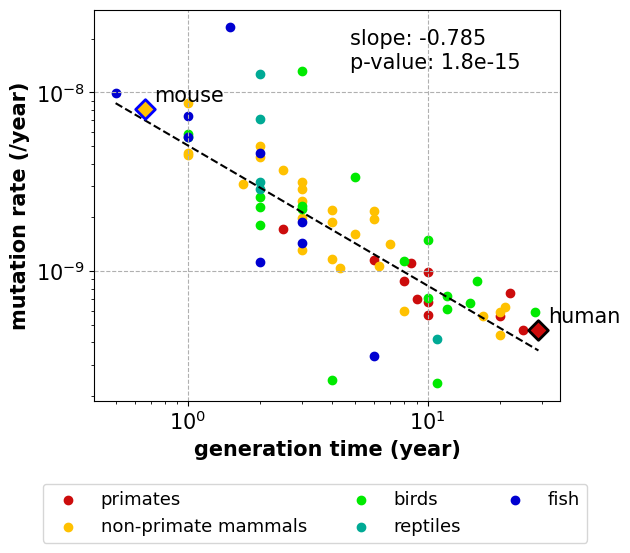

In [13]:
plot_mu_vs_generation(df_vertebrate, vertebrate_group_name2idx_map, cmap)

## Reproductive longevity model
The classical reproductive longetivity model assumes that the per-generation mutation load can be modelled as follows:
$\mu_{\textit{gen}} = B + M(g - p)$ where $B$ is the pre-puberty mutation load, and $M$ is the post-puberty annual mutation load, $g$ is generation time and $p$ is age at puberty. It is assumed that both $B$ and $M$ are constants across species. In human $B=6.35\times 10^{-9}$ and $M=3.5\times 10^{-10}$. In mice, $B=3.75\times 10^{-9}$ and $M=1.64\times 10^{-9}$. The annual mutation rate therefore can be estimated as follows:
$\mu_{\textit{year}} = \frac{B}{g} + M(1-P)$$ where $P=\frac{p}{g}$, this was estimated to be 0.419 using mammalian data.

In the relaxed model, we assume that $B=b\cdot g^{\beta}$ and $M = m \cdot g^{\alpha}$. It is estimated that $(m, \alpha) = (1.24\times 10^{-9}, -0.413)$ and $(b, \beta) = (4.0\times 10^{-9}, 0.126)$. The annual mutation rate therefore is modelled as follows:
$\mu_{\textit{year}} = b\cdot g^{\beta-1} + m\cdot g^{\alpha}(1-P)$.


In [11]:
## helper functions to plot data generated from R
def load_and_plot_r_regression_output(r_filename, x_bounds, text_pos=(0.7, 0.85), fontsize=15, log_scale=True, ax=None, 
                                      label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    df = pd.read_csv(r_filename)
    intercept = df["intercept"].to_numpy()[0]
    slope = df["slope"].to_numpy()[0]
    p_val_slope = df["slope.p"].to_numpy()[0]
    if log_scale is True:
        plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=text_pos, fontsize=fontsize, p_value=p_val_slope, ax=ax, 
                                         label=label, linestyle=linestyle, linewidth=linewidth, alpha=alpha, color=color)
    else:
        plot_regression_line_on_linearscale(intercept, slope, x_bounds, text_pos=text_pos, fontsize=fontsize, p_value=p_val_slope, ax=ax, 
                                            label=label, linestyle=linestyle, linewidth=linewidth, alpha=alpha, color=color)
        
    return [intercept, slope]
    
def plot_regression_line_on_linearscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None, 
                                        label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axline((0, intercept), slope=slope, linestyle=linestyle, linewidth=linewidth, label=label, alpha=alpha, color=color)
    if p_value:
        p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}"
        text = f"slope: {slope:.3f}\np-value: {p_val_str}"
    else:
        text = f"slope: {slope:.3f}"
    ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize)
    
def plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None, 
                                     label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    if ax is None:
        fig, ax = plt.subplots()
    y = np.power(10, intercept) * np.power(x_bounds, slope)
    ax.plot(x_bounds, y, linestyle=linestyle, linewidth=linewidth, label=label, alpha=alpha, color=color)
    if p_value:
        p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}"
        text = f"slope: {slope:.3f}\np-value: {p_val_str}"
    else:
        text = f"slope: {slope:.3f}"
    ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize)

In [121]:
# Dog, Goat, Guinea pig, Siamese fighting fish, Common carp, Domestic cat, Chicken, House mouse, Pig, Alpaca
domesticated_list = ["canis_lupus_familiaris", "capra_hircus", "cavia_aperea", "betta_splendens", "cyprinus_carpio", "felis_catus", "gallus_gallus", "mus_musculus", "sus_scrofa", "vicugna_pacos"]

def compute_residual_sum_of_squares(y_obs, y_pred):
    return np.sum(np.square(y_obs - y_pred))

def u_gen_longevity_fn(B, M, P):
    def f(generation_time):
        return B + M * (generation_time - P * generation_time)
    return f
    
def u_year_longevity_fn(B, M, P):
    def f(generation_time):
        return (B + M * (generation_time - P * generation_time)) / generation_time
    return f

def u_gen_relaxed_fn(b, beta, m, alpha, P):
    def f(generation_time):
        return b * generation_time ** (beta) + m * generation_time ** (alpha) * (generation_time - P * generation_time)
    return f
    
def u_year_relaxed_fn(b, beta, m, alpha, P):
    def f(generation_time):
        return (b * generation_time ** (beta) + m * generation_time ** (alpha) * (generation_time - P * generation_time)) / generation_time
    return f
    
def plot_longevity_model_prediction_per_generation(df, save_figure=False):
    B_h, M_h = 6.35 * 10**(-9), 3.5 * 10**(-10)
    B_m, M_m = 3.75 * 10**(-9), 1.64 * 10**(-9)
    # B_est, M_est = 8.67946E-09, 3.23132E-10
    P = 0.419

    m, alpha = 1.24 * 10 ** (-9), -0.413
    b, beta = 4.0 * 10 ** (-9), 0.126
    
    g = np.logspace(-0.7, 1.4)
    u_gen_longevity_human = u_gen_longevity_fn(B_h, M_h, P)
    u_gen_longevity_mice = u_gen_longevity_fn(B_m, M_m, P)
    u_gen_relaxed = u_gen_relaxed_fn(b, beta, m, alpha, P) #b * g ** (beta) + m * g ** (alpha) * (g - P * g)

    g_df = df["generation_time_year"].to_numpy()
    # rss_gen = []
    # for u in [u_gen_longevity_human, u_gen_longevity_mice, u_gen_relaxed]:
    #     rss_gen.append(compute_residual_sum_of_squares(df["u_mean"].to_numpy(), u(g_df)))

    # rss_table_output = [["", "longevity (human)", "longevity (mice)", "flexible"], ["rss (u_gen)"] + [f"{x:.2E}" for x in rss_gen]]
    # print(tabulate(rss_table_output))
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    linewidth = 3
    ax.scatter(df["generation_time_year"], df["u_mean"], alpha=0.8, color="gray")
    ax.plot(g, u_gen_relaxed(g), color="red", linewidth=linewidth, label="Variable $\mu_E$ and $\mu_O+\mu_S$ \n(relaxed clock)")
    ax.plot(g, u_gen_longevity_human(g), color="orange", linewidth=linewidth, linestyle=(0, (1, 0.5)), label=r"Human $\mu_E$ and $\mu_O+\mu_S$")
    ax.plot(g, u_gen_longevity_mice(g), color="blue", linewidth=linewidth, linestyle=(0, (1, 0.5)), label=r"Mouse $\mu_E$ and $\mu_O+\mu_S$")

    gen_time = df["generation_time_year"]
    r_filename = f"./output/r/mu_gen_gen.csv"
    load_and_plot_r_regression_output(r_filename, [g[0], g[-1]], text_pos=(0.1, 0.2), ax=ax, 
                                      label="PGLS regression", linestyle="dashed", linewidth=linewidth, alpha=0.8, color="black")
    
    axis_label_font_size, tick_label_font_size, legend_font_size = 18, 15, 15
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size, width=2, length=8)
    ax.tick_params(axis='both', which='minor', width=1, length=4)
    ax.set_xlabel("generation time", fontsize=axis_label_font_size)
    ax.set_ylabel(r"$\mu$ per generation", fontsize=axis_label_font_size)
    ax.legend(fontsize=legend_font_size, loc="upper left")
    
    if save_figure:
        fig.savefig("figures/figure2_longevity_model.pdf", bbox_inches='tight')
    
def estimate_B_M_from_u_gen(u_gen, gen):
    result = stats.linregress(gen, u_gen)
    P = 0.419
    slope, intercept = result.slope, result.intercept
    B = intercept
    M = slope / (1-P)
    print(f"B = {B:2G}, M = {M:2G}")
    poly = np.poly1d([slope, intercept])
    print(intercept, slope, intercept + slope * 25)
    
    fig, ax = plt.subplots()
    ax.scatter(gen, u_gen)
    ax.plot(gen, poly(gen))

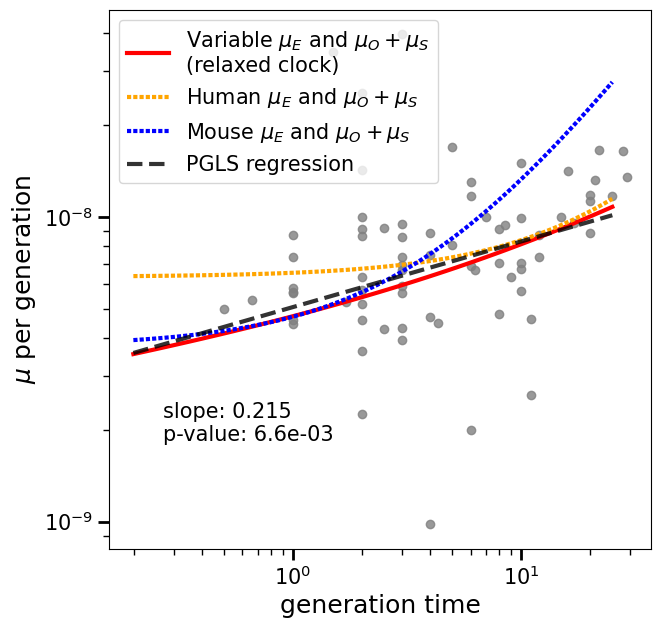

In [122]:
plot_longevity_model_prediction_per_generation(df_vertebrate, save_figure=True)

## Compare log scale vs linear scale data (Supplementary figure 1)

In [128]:
def calculate_lognorm_params(input):
    # https://stackoverflow.com/questions/8870982/how-do-i-get-a-lognormal-distribution-in-python-with-mu-and-sigma
    s, scale = np.var(input), np.exp(np.mean(input))
    rv = stats.lognorm(s, scale=scale)
    return [s, scale, rv]

def calculate_normal_params(input):
    mu, std = np.mean(input), np.std(input)
    rv = stats.norm(mu, std)
    return [mu, std, rv]    
    
def plot_data_distribution(df, save_figure=False):
    gen = df["generation_time_year"].to_numpy()
    x_gen = np.linspace(np.min(gen), np.max(gen), 100)
    log_gen = np.log(gen)
    [_, _, rv_gen_lognorm] = calculate_lognorm_params(log_gen)
    
    mu_g = df["u_mean"].to_numpy()
    x_mu_g = np.linspace(np.min(mu_g), np.max(mu_g), 100)
    log_mu_g = np.log(mu_g)
    [_, _, rv_mu_g] = calculate_lognorm_params(log_mu_g)
    
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    ax[0,0].hist(gen, density=True)
    ax[0,0].plot(x_gen, rv_gen_lognorm.pdf(x_gen), 'k-', lw=2, label="fitted log-normal")
    ax[0,0].legend()
    ax[0,0].set_title("density of generation time", fontsize=15)
    ax[0,1].hist(log_gen)
    ax[0,1].set_title("density of log generation time")

    ax[1,0].hist(mu_g, density=True)
    ax[1,0].plot(x_mu_g, rv_mu_g.pdf(x_mu_g), 'k-', lw=2, label="fitted log-normal")
    ax[1,0].legend()
    ax[1,0].set_title("density of per-gen mutation rate", fontsize=15)
    ax[1,1].hist(log_mu_g)
    ax[1,1].set_title("density of log per-gen mutation rate")
    
    for i in range(2):
        for j in range(2):
            ax[i,j].tick_params(axis='both', which='major', labelsize=15)

    fig.tight_layout()
    
    if save_figure:
        fig.savefig("figures/supp_figure1_lognormal_distribution.pdf", bbox_inches='tight')

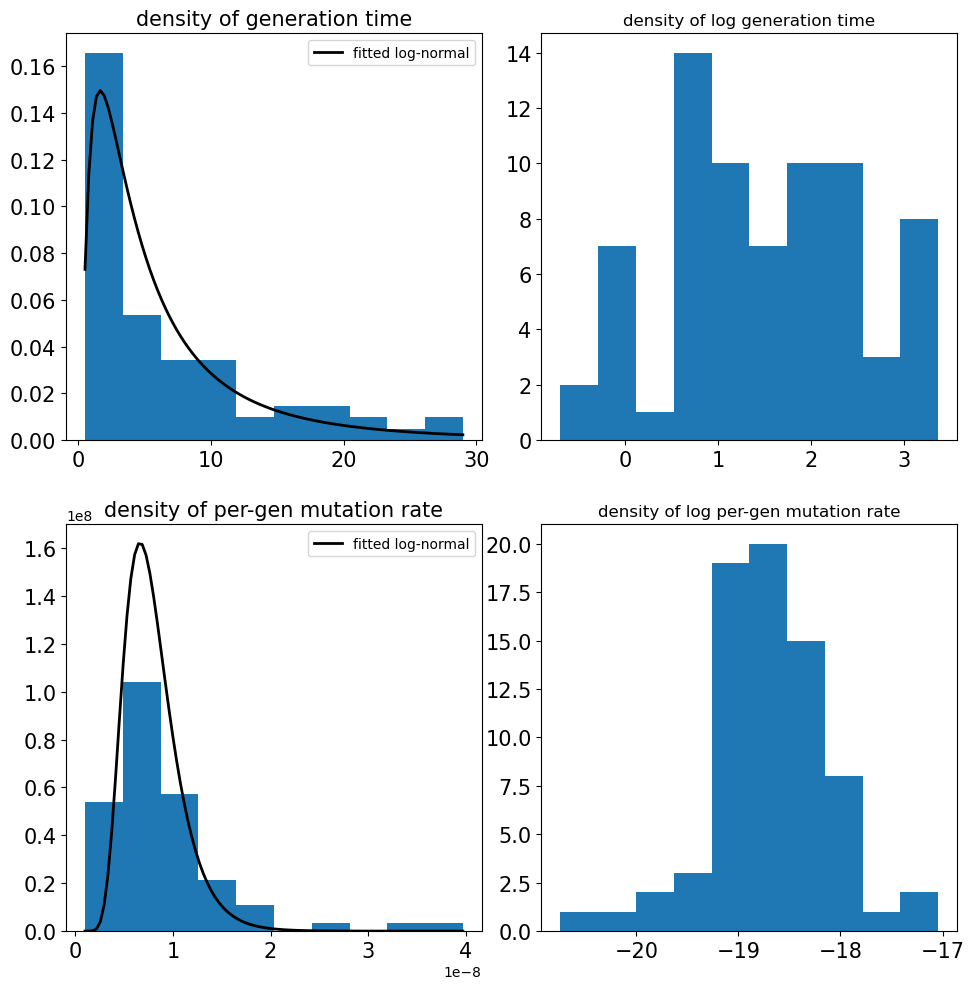

In [129]:
plot_data_distribution(df_vertebrate, save_figure=True)

## Regression of age at first reproduction (AFR, as proxy for age of puberty) vs generation time (Supplementary figure 2)
Dataset taken from paper "Generation Length for Mammals". The regression is performed on species whose generation time was available on the IUCN Red List

In [125]:
def load_and_filter_generation_time_mammal_data():
    df = pd.read_excel("./data/generation_time_for_mammals/Generation Length for Mammals.xlsx")
    df_gma = df[df["Sources_GL"] == "GMA"]
    print(f"{len(df_gma)} species where generation time is provided by IUCN Red List")
    df_gma_afr = df_gma[df_gma["AFR_d"] != "no information"]
    print(f"{len(df_gma_afr)} species left after filtering for species where AFR_d had no information")
    data = df_gma_afr[["AFR_d", "GenerationLength_d"]].to_numpy().astype("float32")
    data /= 365
    gen_min, gen_max = np.min(data[:,1]), np.max(data[:,1])
    print(f"Range of generation time: {gen_min} - {gen_max}")
    return data

def plot_and_regress_age_of_puberty_vs_generation_time(data, save_figure=False):
    fig, ax = plt.subplots()
    afr, gen_time = data[:,0], data[:,1] 
    ax.scatter(gen_time, afr)
    ax.set_xlabel("generation time (years)", fontsize=15)
    ax.set_ylabel("age at first reproduction (years)", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(gen_time, afr)
    print(f"slope={slope}, intercept={intercept}, r-value: {r_value}, p-value: {p_value}")
    reg_fn = np.poly1d([slope, intercept])
    ax.plot(gen_time, reg_fn(gen_time), '--k')

    if save_figure:
        fig.savefig("figures/supp_figure2_age_of_puberty_vs_generation_time.pdf", bbox_inches='tight')

439 species where generation time is provided by IUCN Red List
230 species left after filtering for species where AFR_d had no information
Range of generation time: 2.0 - 52.0
slope=0.4187745108094837, intercept=-0.7095257085600268, r-value: 0.8696168106782604, p-value: 7.899894044403887e-72


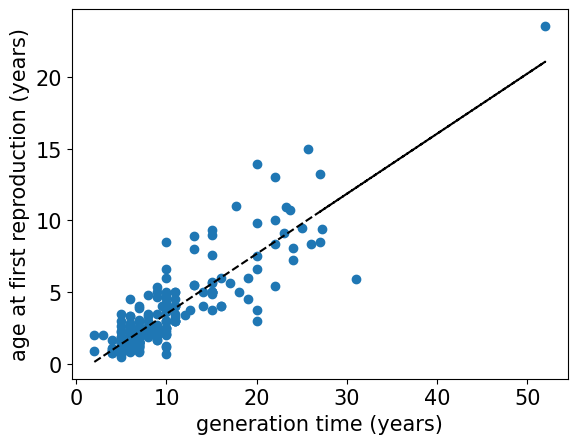

In [127]:
mammal_afr_gen_time = load_and_filter_generation_time_mammal_data()
plot_and_regress_age_of_puberty_vs_generation_time(mammal_afr_gen_time, save_figure=True)